In [1]:
import random
import copy
import enum
from dataclasses import dataclass
from typing import List, Tuple, Type, Union
import random
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [2]:
class TypOkienka(enum.IntFlag):
    A = 1
    B = 2
    C = 4
    
    E = 7
    
@dataclass
class Zadanie:
    typ: TypOkienka
    zlozonosc: int
    __repr__ = lambda self: f"<Zadanie typ={self.typ.name}, zlozonosc={self.zlozonosc}>"


In [3]:
@dataclass
class Wpis:
    dane: Zadanie
    prev: Union[Type["Wpis"], None]
    
    __repr__ = lambda self: f"<Wpis dane={self.dane}>" if self.dane else "<Wpis dane=None>"
    __str__  = lambda self: f"<Wpis dane={self.dane}>" if self.dane else "<Wpis dane=None>"

class ListaJK:
    # PUSH
    #   NEW => LIST
    #
    # APPEND
    #   LIST => NEW
    #
    # POP
    #   FIRST =/=> LIST
    #   return FIRST
    #
    # REMOVE
    #   LIST =/=> LAST
    #   return LAST
    @staticmethod
    def append(lista: Wpis, dane: Wpis) -> Wpis:
        last, _ = __class__._ostatnie(lista)
        last.prev = dane
        return lista

    @staticmethod
    def push(lista: Wpis, dane: Wpis) -> Wpis:
        last_of_dane, _ = __class__._ostatnie(dane)
        last_of_dane.prev = lista
        return dane
        
    @staticmethod
    def pop(lista: Wpis) -> Tuple[Wpis, Zadanie]:
        dane = lista.dane
        return lista.prev, dane

    @staticmethod
    def remove(lista: Wpis) -> Tuple[Wpis, Zadanie]:
        if lista.prev:
            last = lista
            while last.prev.prev:
                last = last.prev
            dane = last.prev.dane
            last.prev = None
            return dane
        else:
            return __class__.pop(lista)
        
    @staticmethod
    def find_and_remove(lista: Wpis, typ_okienka: TypOkienka) -> Tuple[Union[Wpis, None], Union[Zadanie, None]]:
        if lista:
            if lista.prev:
                if lista.dane.typ & typ_okienka:
                    return lista.prev, lista.dane
                last = lista
                while last.prev.prev and not (last.prev.dane.typ & typ_okienka):
                    last = last.prev
                if last.prev.dane.typ & typ_okienka:
                    dane = last.prev.dane
                    last.prev = last.prev.prev
                    return lista, dane
                else:
                    return lista, None
            elif lista.dane.typ & typ_okienka:
                return None, lista.dane
            else:
                return lista, None
        else:
            return None, None

    @staticmethod        
    def _ostatnie(lista) -> Tuple[Wpis, int]:
        i = 1
        last = lista
        while last.prev:
            last = last.prev
            i += 1
        return last, i
    
    @staticmethod  
    def length(lista) -> int:
        _, length = __class__._ostatnie(lista)
        return length
    
    @staticmethod  
    def to_list(lista):
        nowa_lista = []
        last = lista
        while last.prev:
            nowa_lista.append(last.dane)
            last = last.prev
        return nowa_lista
            

In [4]:
class Okienko:
    
    def __init__(self, typ: TypOkienka):
        self.typ = typ
        
        self.zlozonosc = 0
        self.obsluzeni = 0
        self.zadanie = None
        
    def krok(self) -> bool:
        if not self.zlozonosc:
            self.zadanie = None
            self.zlozonosc = 0
            return True
        self.zlozonosc -= 1
        return False
    
    def nowe_zadanie(self, zadanie: Zadanie) -> None:
        self.obsluzeni += 1
        self.zadanie = zadanie
        self.zlozonosc = zadanie.zlozonosc

    __bool__ = lambda self: True if zadanie else False
    __repr__ = lambda self: f"<Okienko typ={self.typ.name}>"
        
class Urzad:
    def __init__(self, deklaracja_okienek: List[Tuple[TypOkienka, int]]):
        self.okienka = []
        for okienko in deklaracja_okienek:
            for _ in range(okienko[1]):
                self.okienka.append(Okienko(okienko[0]))
                
    def krok(self, lista: Wpis) -> Tuple[bool, Wpis]:
        done = True
        for okienko in self.okienka:
            if not okienko.zadanie:
                lista, zadanie = ListaJK.find_and_remove(lista, okienko.typ)
                if zadanie:
                    okienko.nowe_zadanie(zadanie)
                    done = False
            else:
                if okienko.krok():
                    lista, zadanie = ListaJK.find_and_remove(lista, okienko.typ)
                    if zadanie:
                        okienko.nowe_zadanie(zadanie)
                        done = False
        for okienko in self.okienka:
            if okienko.zadanie:
                done = False
        return done, lista
    
    def pisz_tytul(self):
        for okienko in self.okienka:
            print(f"\t{okienko.typ.name*4}", end="")
        print()
        
    def pisz_stan(self):
        for okienko in self.okienka:
            if okienko.zadanie:
                print(f"{okienko.zadanie.typ.name} {okienko.zlozonosc}", end="\t")
            else:
                print(f"{okienko.zadanie}", end="\t")
        print()
    
    def pisz_podsumowanie(self):
        suma = 0
        for okienko in self.okienka:
            suma += okienko.obsluzeni
            print(f"\t{okienko.obsluzeni}", end="")
        print("\nSuma: ",suma)

In [5]:
mozliwe_okienka = [TypOkienka.A, TypOkienka.B, TypOkienka.C]

def generuj_zadanie():
    return Zadanie(
        typ=random.choice(mozliwe_okienka),
        zlozonosc=random.randint(1,10)
    )

lista = Wpis(generuj_zadanie(), None)
for _ in range(29):
    lista = ListaJK.push(lista, Wpis(generuj_zadanie(), None))

In [6]:
urzad = Urzad([(TypOkienka.A, 3), (TypOkienka.B, 3), (TypOkienka.C, 3), (TypOkienka.E, 1)])
urzad.pisz_tytul()
koniec = False
iteracje = 0
while not koniec:
    iteracje += 1
    koniec, lista = urzad.krok(lista)
    print(f"{iteracje}", end="\t")
    urzad.pisz_stan()
    
urzad.pisz_podsumowanie()
print("Ilość iteracji: ", iteracje)

	AAAA	AAAA	AAAA	BBBB	BBBB	BBBB	CCCC	CCCC	CCCC	EEEE
1	A 1	A 5	A 3	B 7	B 10	B 10	C 5	C 7	C 4	A 7	
2	A 0	A 4	A 2	B 6	B 9	B 9	C 4	C 6	C 3	A 6	
3	A 5	A 3	A 1	B 5	B 8	B 8	C 3	C 5	C 2	A 5	
4	A 4	A 2	A 0	B 4	B 7	B 7	C 2	C 4	C 1	A 4	
5	A 3	A 1	A 5	B 3	B 6	B 6	C 1	C 3	C 0	A 3	
6	A 2	A 0	A 4	B 2	B 5	B 5	C 0	C 2	C 8	A 2	
7	A 1	A 9	A 3	B 1	B 4	B 4	C 2	C 1	C 7	A 1	
8	A 0	A 8	A 2	B 0	B 3	B 3	C 1	C 0	C 6	A 0	
9	A 2	A 7	A 1	B 8	B 2	B 2	C 0	C 5	C 5	B 8	
10	A 1	A 6	A 0	B 7	B 1	B 1	C 7	C 4	C 4	B 7	
11	A 0	A 5	A 2	B 6	B 0	B 0	C 6	C 3	C 3	B 6	
12	A 5	A 4	A 1	B 5	B 6	B 2	C 5	C 2	C 2	B 5	
13	A 4	A 3	A 0	B 4	B 5	B 1	C 4	C 1	C 1	B 4	
14	A 3	A 2	None	B 3	B 4	B 0	C 3	C 0	C 0	B 3	
15	A 2	A 1	None	B 2	B 3	B 4	C 2	C 5	C 4	B 2	
16	A 1	A 0	None	B 1	B 2	B 3	C 1	C 4	C 3	B 1	
17	A 0	None	None	B 0	B 1	B 2	C 0	C 3	C 2	B 0	
18	None	None	None	B 8	B 0	B 1	None	C 2	C 1	B 7	
19	None	None	None	B 7	B 1	B 0	None	C 1	C 0	B 6	
20	None	None	None	B 6	B 0	None	None	C 0	None	B 5	
21	None	None	None	B 5	None	None	None	None	None	B 4	
22	No

### Zaproponować jakieś usprawnienie przyspieszające wyszukanie zadania danego typu.
1. Zamiast głupio zawsze przeszukiwać całą listę w poszukiwaniu elementu który w niej niekoniecznie jest można przed rozpoczęciem działania stworzyć dict'a, który będzie trzymał w sobie ilość pozostałych typów zadań. Eg. 
```python
dict = {
    TypOkienka.A: 10,
    TypOkienka.B: 12,
    TypOkienka.C: 8,
}
```
Następnie przed wyszukiwaniem danego elementu z listy wystarczy sprawdzić czy dany element jest w liście z dodatnią ilością wystąpień.

2. Gdy w liście nie ma więcej zadań danego typu można "zamknąć" okienko.

In [7]:
urzad8 = Urzad([(TypOkienka.A, 2), (TypOkienka.B, 2), (TypOkienka.C, 2), (TypOkienka.E, 2)])
urzad9 = Urzad([(TypOkienka.A, 3), (TypOkienka.B, 3), (TypOkienka.C, 3)])

def generuj_liste(dlugosc: int = 30) -> Wpis:
    lista = Wpis(generuj_zadanie(), None)
    for _ in range(dlugosc):
        lista = ListaJK.push(lista, Wpis(generuj_zadanie(), None))
    return lista
    
def policz_iteracje(urzad: Urzad, lista: Wpis) -> int:
    koniec = False
    iteracje = 0
    while not koniec:
        iteracje += 1
        koniec, lista = urzad.krok(lista)
    return iteracje

lista_dla_8 = generuj_liste()
lista_dla_9 = copy.deepcopy(lista_dla_8)

print(policz_iteracje(urzad8, lista_dla_8))
print(policz_iteracje(urzad9, lista_dla_9))

30
30


In [8]:
dla_8 = []
dla_9 = []
dla_0 = []

for _ in range(99):
    urzad8 = Urzad([(TypOkienka.A, 2), (TypOkienka.B, 2), (TypOkienka.C, 2), (TypOkienka.E, 2)])
    urzad9 = Urzad([(TypOkienka.A, 3), (TypOkienka.B, 3), (TypOkienka.C, 3)])
    urzad0 = Urzad([(TypOkienka.A, 1), (TypOkienka.B, 1), (TypOkienka.C, 1), (TypOkienka.E, 5)])
    lista_dla_8 = generuj_liste()
    lista_dla_9 = copy.deepcopy(lista_dla_8)
    lista_dla_0 = copy.deepcopy(lista_dla_8)
    
    dla_8.append(policz_iteracje(urzad8, lista_dla_8))
    dla_9.append(policz_iteracje(urzad9, lista_dla_9))
    dla_0.append(policz_iteracje(urzad0, lista_dla_0))

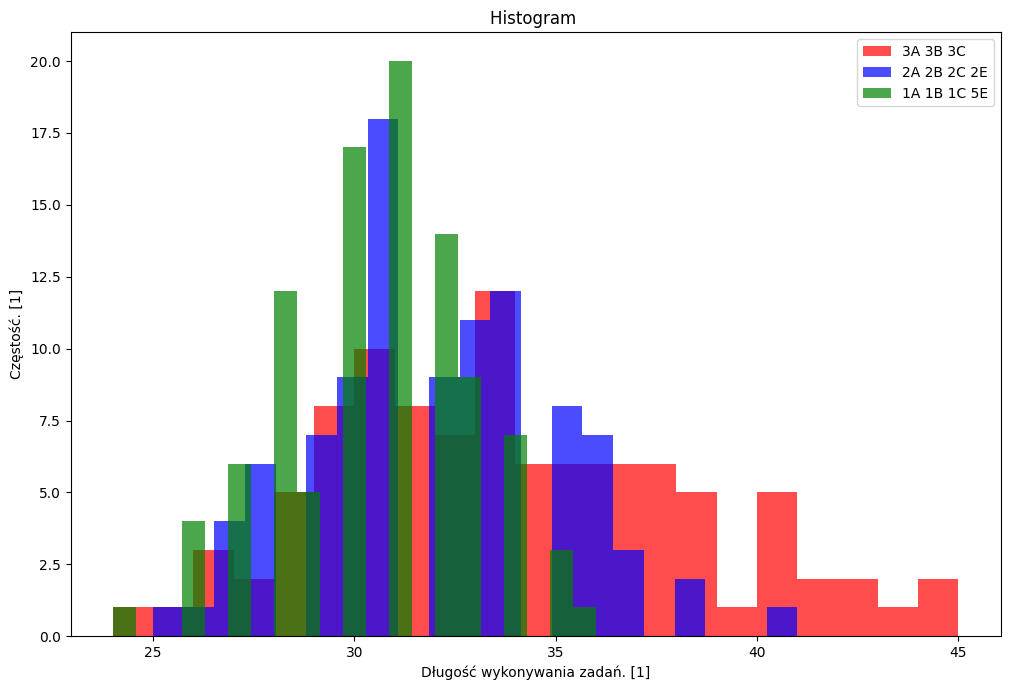

In [10]:
plt.figure()
bins = max([max(dla_8) - min(dla_8), max(dla_9) - min(dla_9)])
plt.hist(dla_9, bins, stacked=True, label="3A 3B 3C", alpha=0.7, color="red")
plt.hist(dla_8, bins, stacked=True, label="2A 2B 2C 2E", alpha=0.7, color="blue")
plt.hist(dla_0, bins, stacked=True, label="1A 1B 1C 5E", alpha=0.7, color="green")
plt.legend()
plt.xlabel("Długość wykonywania zadań. [1]")
plt.ylabel("Częstość. [1]")
plt.title("Histogram ")
plt.show()

Okienko typu E działa jak dodatkowe okienko które zabiera z kolejki pierwsze następne zadanie. Jego użyteczność pojawia się pod koniec wykonywania gdy któreś z okienek ma więcej zadań niż reszta lub gdy zostaje w liście jeden typ zadań. W przypadku 3 po 3 po 3 gdy dla przykładu okienka A i B zakończą swoją pracę, maksymalna ilość okienek wykonującą ten typ zadań wynosi 3, w przypadku 2 po 2 po 2 po 2, maksymalna ilość wynosi 4. (to chyba wiadomo że 4 > 3) 

Moim zdaniem, najlepszą metodą na zwiększenie prędkości jest paralelizacja. Stworzenie większej ilości okienek ogólnych typu E jest lepsze od takiej samej ilości okienek typu ABC. (na wykresie zielony kolor)